In [ ]:
# https://csaybar.github.io/blog/2019/05/19/titanic/

In [1]:
!pip3 install lightgbm
!pip3 install bayesian-optimization

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:

import sklearn
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

import urllib

import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/alloc/data/fury_fda-general-analysis/') # nombre de la ruta
from commons.modelling_tools import clean_dataset, bayes_parameter_opt_lgb
import commons.metrics as met


# read data

In [5]:
# Download the dataset
url = 'https://raw.githubusercontent.com/csaybar/Titanic/master/'
urllib.request.urlretrieve(url+'train.csv', 'train.csv')
urllib.request.urlretrieve(url+'test.csv', 'test.csv')

#Let’s read in and take a peek at the data.
basedataset = pd.read_csv('train.csv')
dataset_valid =  pd.read_csv('test.csv')

In [6]:
basedataset.rename(columns={'Survived': 'target'}, inplace=True)

In [7]:
basedataset.groupby(['target'], as_index=False).agg({"PassengerId":"count"})

,target,PassengerId
0,0,549
1,1,342


In [8]:
basedataset.head(3)

,PassengerId,target,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# data preparation

In [9]:
X = basedataset[basedataset.columns.difference(['target'])]
X = clean_dataset(X,categorical_cols=['Sex','Cabin','Embarked'],canary=3,vars_to_drop=['Name','Ticket'])
y = basedataset['target'].astype('int')

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/alloc/data/fury_fda-general-analysis/commons/modelling_tools.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d

canary features


/alloc/data/fury_fda-general-analysis/commons/modelling_tools.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['canary_{}'.format(c)] = np.random.uniform(0,1,len(df))


In [10]:
### Modelo LIGHTGBM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# train df
lgb_train = lgb.Dataset(X_train, y_train)

# test df
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [11]:
# optimizar
opt_params = bayes_parameter_opt_lgb(X_train, y_train, X_test, y_test, init_round=5, opt_round=15, random_seed=6)

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8392   |  0.9098   |  6.576    |  0.5822   |  2.724    |  1.271    |  0.06494  |  6.746    |  45.13    |  0.0964   |  23.42    |
|  2        |  0.8453   |  0.9583   |  5.644    |  0.5544   |  4.628    |  0.2131   |  0.009626 |  5.081    |  42.47    |  0.07804  |  40.45    |
|  3        |  0.8399   |  0.9957   |  6.996    |  0.4692   |  3.903    |  0.3548   |  0.06435  |  5.572    |  47.51    |  0.05266  |  24.51    |
|  4        |  0.8406   |  0.8529   |  6.871    |  0.4649   |  2.842    |  0.05637  |  0.06215  |  7.442    |  32.76    |  0.09443  |  33.86    |
|  5        |  0.8533   |  0.8719   |  5.185    |  0.6581   |  0.3011   |  2.0      |  0.06739  |  5.839    |  10.8     |  0

In [12]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'l1','l2_root','mape', 'rmse', 'auc'},
        'learning_rate': opt_params['params']['learning_rate'],
        'feature_fraction': opt_params['params']['feature_fraction'],
        'max_depth': opt_params['params']['max_depth'],
        'min_child_weight': opt_params['params']['min_child_weight'],
        'min_split_gain': opt_params['params']['min_split_gain'],
        'lambda_l1': opt_params['params']['lambda_l1'],
        'lambda_l1': opt_params['params']['lambda_l2'],
        'num_leaves': opt_params['params']['num_leaves'],
        'bagging_freq': int(opt_params['params']['bagging_freq']),
        'n_jobs':40,
        'verbose': 0
    }

In [13]:
# Entreno el modelo (con los codigos de MLA)
# https://github.com/Microsoft/LightGBM/blob/2e93cdab9eee02d4d7f5cb3b6b31128dec94e25e/examples/python-guide/plot_example.py#L32-L47
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                evals_result=evals_result,
                valid_sets=lgb_eval,
                early_stopping_rounds=30,
                verbose_eval=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.846184	valid_0's l2: 0.226479	valid_0's rmse: 0.475898	valid_0's l1: 0.464401	valid_0's mape: 0.464401
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.852699	valid_0's l2: 0.220806	valid_0's rmse: 0.4699	valid_0's l1: 0.45852	valid_0's mape: 0.45852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.840775	valid_0's l2: 0.218905	valid_0's rmse: 0.467873	valid_0's l1: 0.456411	valid_0's mape: 0.456411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 0.831182	valid_0's l2: 

# metricas

In [14]:
y_pred = gbm.predict(X_test)

ROC curve & AUC..


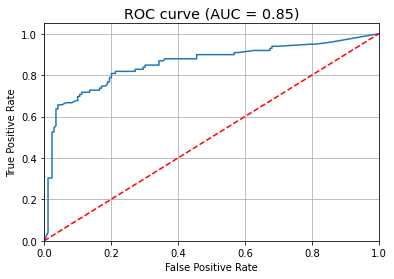

In [15]:
met.plot_roc_curve(y_test,y_pred ,'model1')

In [16]:
max_ks, cutoff = met.best_cutoff(y_test, y_pred,'model1')
met.best_cutoff(y_test, y_pred,'model1')

Best cutoff..
Best cutoff..


(0.6151455382224613, 0.45723373111778537)

In [17]:
reporte = met.obtain_metrics(y_pred, y_test, cutoff, max_ks)
met.obtain_metrics(y_pred, y_test, cutoff, max_ks)

{'Cutoff': 0.457,
 'KS': 0.615,
 'Accuracy': 84.7,
 'Precision (1)': 90.28,
 'Recall (1)': 65.66,
 'Mean absolute error': 0.15,
 'mean squared error': 0.15,
 'Root mean squared error': 0.39}

> Confussion matrix


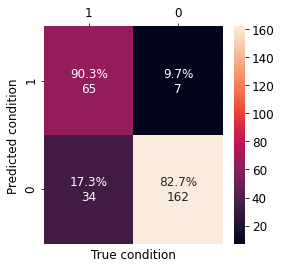

> Reporte:
1


In [18]:
y_cut_off = y_pred >= cutoff
cm, annot = met.cm_analysis(y_test, y_cut_off)
met.print_confussion_matrix_and_report(cm, annot, '1')

In [19]:
print(met.classification_report(y_test,y_cut_off))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       169
           1       0.90      0.66      0.76        99

    accuracy                           0.85       268
   macro avg       0.86      0.81      0.82       268
weighted avg       0.85      0.85      0.84       268



In [20]:
met.ks_table(y_test, y_pred,decimal=1)

,prob_group,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,TP,FP,TN,FN,Precision_(1),recall_(1),F1-score(1),Precision_(0),recall_(0),F1-score(0),KS
0,0.6,0.604139,0.604139,4,2,4.04%,1.18%,4.04%,1.18%,4,2,167,95,0.67,0.04,0.08,0.64,0.99,0.78,2.9
1,0.5,0.506255,0.597404,45,2,45.45%,1.18%,49.49%,2.37%,49,4,165,50,0.92,0.49,0.64,0.77,0.98,0.86,47.1
2,0.4,0.402008,0.499820,32,32,32.32%,18.93%,81.82%,21.30%,81,36,133,18,0.69,0.82,0.75,0.88,0.79,0.83,60.5
3,0.3,0.300328,0.398836,12,80,12.12%,47.34%,93.94%,68.64%,93,116,53,6,0.44,0.94,0.60,0.90,0.31,0.46,25.3
4,0.2,0.278279,0.296779,6,53,6.06%,31.36%,100.00%,100.00%,99,169,0,0,0.37,1.00,0.54,NaN,0.00,NaN,0.0


In [21]:
met.quantile_table(y_test,y_pred,n_quantile=5)

,prob_group,min_prob,max_prob,avg_prob,events,nonevents,obs,prop_target,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
0,4,0.499820,0.604139,0.557023,50,4,54,0.925926,50.51%,2.37%,0.505051,0.023669,48.1
1,3,0.417311,0.489835,0.447439,25,28,53,0.471698,25.25%,16.57%,0.757576,0.189349,56.8
2,2,0.329317,0.417269,0.368271,12,42,54,0.222222,12.12%,24.85%,0.878788,0.437870,44.1
3,1,0.296779,0.327806,0.316757,6,44,50,0.120000,6.06%,26.04%,0.939394,0.698225,24.1
4,0,0.278279,0.293376,0.284429,6,51,57,0.105263,6.06%,30.18%,1.000000,1.000000,0.0


# features

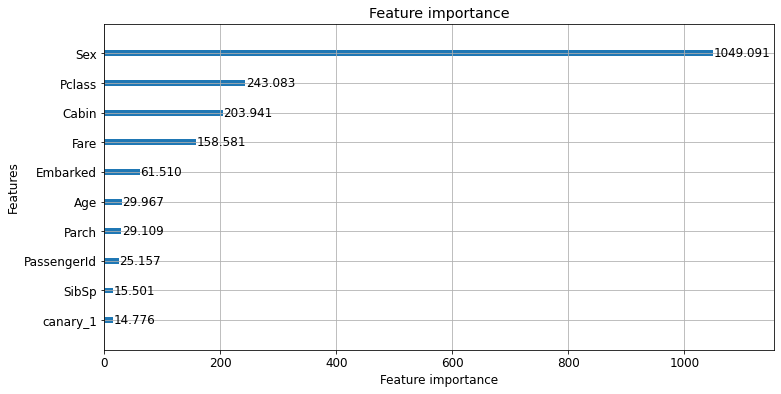

In [22]:
lgb.plot_importance(gbm, figsize=(12, 6),importance_type='gain', max_num_features=20,grid=True);

# "mujeres y ninos primero"

In [24]:
df_imporance = met.get_importance_df(X_test,y_test,gbm)
df_imporance.sort_values(by=['importance_gain'],ascending=False).head(20)

,feature,importance_gain,importance_split,trn_score
7,Sex,1049.091202,9,0.854701
6,Pclass,243.082998,6,0.854701
1,Cabin,203.940590,23,0.854701
3,Fare,158.580804,17,0.854701
2,Embarked,61.510400,6,0.854701
0,Age,29.967390,7,0.854701
4,Parch,29.108789,11,0.854701
5,PassengerId,25.156899,11,0.854701
8,SibSp,15.500560,3,0.854701
9,canary_1,14.776247,14,0.854701
